Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [14]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [15]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from pandas_profiling import ProfileReport
from scipy.stats import randint, uniform

In [17]:
def wrangle(df):
    df = df.copy()
    df['latitude'] = df['latitude'].replace(-2e-08, 0)
    
    cols_with_zeros = ['longitude', 'latitude', 'construction_year',
                      'gps_height', 'population']
    
    for col in cols_with_zeros:
        df[col] = df[col].replace(0, np.nan)
        df[col+'_MISSING'] = df[col].isnull()
        
    duplicates = ['quantity_group', 'payment_type']
    df = df.drop(columns = duplicates)
    
    unusable_variance = ['recorded_by']
    #removed id to keep it in test set
    df = df.drop(columns = unusable_variance)
    
    #deal with amount_tsh distribution
    df["amount_tsh_zero"] = df["amount_tsh"] == 0
    df["log_amount_tsh"] = np.log(df["amount_tsh"] + 1)
    
    df["num_private_is_zero"] = df["num_private"]==0
    
    # for some high-cardinality data, keep top-30 values and everything else other
    top50f = df["funder"].value_counts()[:50].index
    df.loc[~df['funder'].isin(top50f), "funder"] = "other"
    top50i = df["installer"].value_counts()[:50].index
    df.loc[~df["installer"].isin(top50i), "installer"] = "other"
    top50w = df["wpt_name"].value_counts()[:50].index
    df.loc[~df["wpt_name"].isin(top50w), "wpt_name"] = "other"
    top50s = df["subvillage"].value_counts()[:50].index
    df.loc[~df["subvillage"].isin(top50s), "subvillage"] = "other"
    
    #set categoricals as categoricals
    df["region_code"] = df["region_code"].astype("category")
    df["district_code"] = df["district_code"].astype("category")
    
    df['date_recorded'] = pd.to_datetime(df['date_recorded'], infer_datetime_format = True)
    
    df['year_recorded'] = df['date_recorded'].dt.year
    df['month_recorded'] = df['date_recorded'].dt.month
    df['day_recorded'] = df['date_recorded'].dt.day
    df = df.drop(columns = 'date_recorded')
    
    #df['years'] = df['year_recorded'] - df['construction_year']
    # too correlated with construction year
    df['years_MISSING'] = df['construction_year'].isnull()
    
    return df

In [18]:
train = wrangle(train)
test = wrangle(test)

In [19]:
train, val = train_test_split(train, train_size = .8, test_size = .2)

In [20]:
target = 'status_group'
features = train.drop([target], axis = 1).columns.tolist()

In [21]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = "median", add_indicator = True),
    RandomForestClassifier(random_state = 100)
)

param_distributions = { 
    'randomforestclassifier__n_estimators': randint(50, 1300),
    'randomforestclassifier__max_depth': [5, 15, 25, 35, 45, None]
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train)

from skopt import BayesSearchCV

parameter ranges are specified by one of below
from skopt.space import Real, Categorical, Integer

from sklearn.datasets import load_iris from sklearn.svm import SVC from sklearn.model_selection import train_test_split

X, y = load_iris(True) X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV( SVC(), { 'C': Real(1e-6, 1e+6, prior='log-uniform'), 'gamma': Real(1e-6, 1e+1, prior='log-uniform'), 'degree': Integer(1,8), 'kernel': Categorical(['linear', 'poly', 'rbf']), }, n_iter=32 )

executes bayesian optimization
opt.fit(X_train, y_train)

print('Best hyperparameters', search.best_params_)
print('Accuracy', search.best_score_)

pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

In [22]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = "median", add_indicator = True),
    RandomForestClassifier(max_depth = 25, n_estimators = 1275, random_state = 100)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region',
                                      'region_code', 'district_code', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_qua...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=25, max_features='auto',
                                 

In [23]:
y_pred = pipeline.predict(X_val)

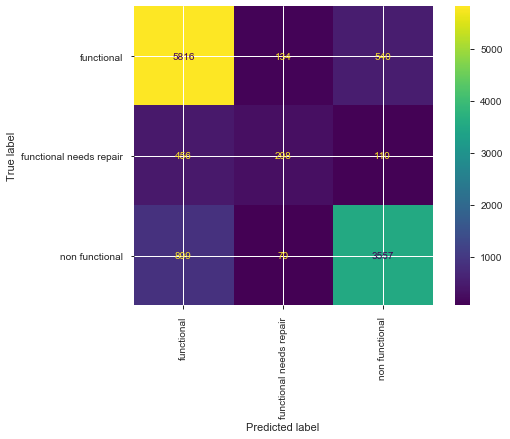

In [25]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format = '.0f', xticks_rotation = 'vertical')